## Import Libraries

In [2]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import matplotlib.image as img
import cv2
import scipy.ndimage
import pathlib
import warnings
import shutil
import zipfile 
import os
import re
import seaborn as sns
import pandas as pd
import glob
import tifffile
from skimage.io import imread
import re
from PIL import Image
import csv
import numpy as np
import math
import tifffile as tiff
warnings.filterwarnings("ignore")

In [3]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [4]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('FISH_Processing/config.yml')

## Connecting to NAS and Downloading data

In [4]:
def read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name,mandatory_substring,local_folder_path):
    # This function iterates over all zip files in a remote directory and download them to a local directory
    list_remote_files=[]
    list_local_files =[]
    for folder in list_dirs:
        list_files = fa.NASConnection(path_to_config_file,share_name = share_name).read_files(folder,timeout=60)
        for file in list_files:
            if ('.zip' in file) and (mandatory_substring in file):   # add an argument with re conditions 
                # Listing all zip files
                zip_file_path = pathlib.Path().joinpath(folder,file)
                list_remote_files.append (zip_file_path)
                list_local_files.append(pathlib.Path().joinpath(local_folder_path,zip_file_path.name)) 
                # downloading the zip files from NAS
                fa.NASConnection(path_to_config_file,share_name = share_name).download_file(zip_file_path, local_folder_path,timeout=200)
    return list_local_files

In [5]:
def unzip_local_folders(list_local_files,local_folder_path):
    list_local_folders =[]
    for zip_folder in list_local_files:
        # Reads from a list of zip files
        file_to_unzip = zipfile.ZipFile(str(zip_folder)) # opens zip
        temp_folder_name = pathlib.Path().joinpath(local_folder_path, zip_folder.stem)
        if (os.path.exists(temp_folder_name)) :
            shutil.rmtree(temp_folder_name)
            os.makedirs(temp_folder_name) # make a new directory
        # Iterates for each file in zip file
        for file_in_zip in file_to_unzip.namelist():
            # Extracts data to specific folder
            file_to_unzip.extract(file_in_zip,temp_folder_name)
        # Closes the zip file
        file_to_unzip.close()
        # removes the original zip file
        os.remove(pathlib.Path().joinpath(local_folder_path, zip_folder.name))
        list_local_folders.append(temp_folder_name)
    return list_local_folders


In [6]:
def download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200):
    # Downloading data from NAS
    local_folder_path = pathlib.Path().absolute().joinpath('temp_' + data_folder_path.name)
    fa.NASConnection(path_to_config_file,share_name = share_name).copy_files(data_folder_path, local_folder_path,timeout=timeout)
    local_data_dir = local_folder_path     # path to a folder with images.
    # Downloading masks from NAS
    if not (path_to_masks_dir is None):
        local_folder_path_masks = pathlib.Path().absolute().joinpath( path_to_masks_dir.stem  )
        zip_file_path = local_folder_path_masks.joinpath( path_to_masks_dir.stem +'.zip')
        print(zip_file_path)
        fa.NASConnection(path_to_config_file,share_name = share_name).download_file(path_to_masks_dir, local_folder_path_masks,timeout=timeout)
        # Unzip downloaded images and update mask directory
        file_to_unzip = zipfile.ZipFile(str(zip_file_path)) # opens zip
        # Iterates for each file in zip file
        for file_in_zip in file_to_unzip.namelist():
            # Extracts data to specific folder
            file_to_unzip.extract(file_in_zip,local_folder_path_masks)
        # Closes the zip file
        file_to_unzip.close()
        # removes the original zip file
        os.remove(zip_file_path)
        masks_dir = local_folder_path_masks
    else:
        masks_dir = None
    return local_data_dir, masks_dir

----

# Downloading Mask, Original Image, and Dataframes

----

In [18]:
## Getting analysis zip location

def MS2_Cy3(mandatory_substring):
    list_dirs=('smFISH_images/Linda_smFISH_images/Confocal/20210518/MS2-Cy3',
                'smFISH_images/Linda_smFISH_images/Confocal/20210518/MS2-Cy5')
    
    list_labels = [ 'test']
    plot_title_suffix= "test"
    mandatory_substring = mandatory_substring      
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

def A549(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_woSTM_GoldMedia',
    'smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_30ngmL_IL1B_2h_GoldMedia')
    #'smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_NFKBIA_woSTM',
    #'smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_NFKBIA_100nMDEX_2h' )

    list_labels = [ 'COX2_wo','COX2_2h_30ng_ILB','NFKBIA_wo','NFKBIA_2h_100ng_DEx']
    plot_title_suffix= "COX2_NFKBIA"
    mandatory_substring = mandatory_substring      #'nuc_90__cyto_200__psfz_350__psfyx_110__ts_500'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring


def MS2_Cy5_TPL(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim',
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM')

    list_labels = [ 'COX2_wo','COX2_2h_30ng_ILB','NFKBIA_wo','NFKBIA_2h_100ng_DEx']
    plot_title_suffix= "COX2_NFKBIA"
    mandatory_substring = mandatory_substring      #'nuc_90__cyto_200__psfz_350__psfyx_110__ts_500'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring


def DUSP1(mandatory_substring):
    list_dirs=(
    'smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_0nM_0min_Control_092022' ,
    'smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_1pM_75min_092022' )

    list_labels = [ 'COX2_wo','COX2_2h_30ng_ILB','NFKBIA_wo','NFKBIA_2h_100ng_DEx']
    plot_title_suffix= "COX2_NFKBIA"
    mandatory_substring = mandatory_substring      #'nuc_90__cyto_200__psfz_350__psfyx_110__ts_500'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

def MS2_Cy5_cyto(mandatory_substring):
    list_dirs=('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim',
                'smFISH_images/Linda_smFISH_images/Confocal/20210518/MS2-Cy5')
    
    list_labels = [ 'test']
    plot_title_suffix= "test"
    mandatory_substring = mandatory_substring      
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

In [17]:
### Remote directories Information for zip files to download
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')

download_data_from_NAS = True

#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_30ngmL_IL1B_2h_GoldMedia')
#path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_30ngmL_IL1B_2h_GoldMedia/masks_A549_COX2_30ngmL_IL1B_2h_GoldMedia___nuc_90__cyto_200.zip')
#list_dirs, list_labels, plot_title_suffix, mandatory_substring = MS2_Cy5(mandatory_substring='nuc_180__cyto_240')

#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_woSTM_GoldMedia')
#path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_woSTM_GoldMedia/masks_A549_COX2_woSTM_GoldMedia__nuc_90__cyto_200.zip')
#list_dirs, list_labels, plot_title_suffix, mandatory_substring = A549(mandatory_substring='nuc_90__cyto_200__psfz_350__psfyx_110__ts_600')

#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')
#path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_60__cyto_180.zip')
#list_dirs, list_labels, plot_title_suffix, mandatory_substring = MS2_Cy5_TPL(mandatory_substring='nuc_60__cyto_180__psfz_350__psfyx_110__ts_300')

#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20210518/MS2-Cy3')
#path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20210518/MS2-Cy3/masks_MS2-Cy3___nuc_90__cyto_200.zip')
#list_dirs, list_labels, plot_title_suffix, mandatory_substring = MS2_Cy3(mandatory_substring='nuc_90__cyto_200__psfz_350__psfyx_110__ts_auto')

#data_folder_path = pathlib.Path('smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_0nM_0min_Control_092022')
#path_to_masks_dir = pathlib.Path('smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_0nM_0min_Control_092022/masks_DUSP1_Dex_Sweep_0nM_0min_Control_092022___nuc_100__cyto_200.zip')
#list_dirs, list_labels, plot_title_suffix, mandatory_substring = DUSP1(mandatory_substring='nuc_100__cyto_200__psfz_320__psfyx_120__ts_auto')

data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')
path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0.zip')
list_dirs, list_labels, plot_title_suffix, mandatory_substring = MS2_Cy5_cyto(mandatory_substring='nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_400')


#path_to_masks_NAS = ‘smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0.zip’
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim'

#ata_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20211019/MS2-CY5-21minTPL')
#path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20211019/MS2-CY5-21minTPL/masks_MS2-CY5-21minTPL___nuc_180__cyto_240')
#list_dirs='smFISH_images/Linda_smFISH_images/Confocal/20211019/MS2-CY5-21minTPL'
#mandatory_substring='nuc_180__cyto_240'


In [19]:
# Download data from NAS
if download_data_from_NAS == True:
    share_name = 'share'
    list_local_files = read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name, mandatory_substring, local_folder_path)
    local_data_dir, masks_dir= download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200)
    list_local_folders = unzip_local_folders(list_local_files,local_folder_path)
else:
    local_data_dir = data_folder_path 
    masks_dir = path_to_masks_dir 

Connection established
Connection established
Files downloaded to: /home/jcook10/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_400.zip
Connection established
Connection established
File Downloaded : ROI005_XY1657814112_Z00_T0_C1.tif
File Downloaded : ROI004_XY1657814111_Z00_T0_C3.tif
File Downloaded : ROI001_XY1657814108_Z00_T0_C1.tif
File Downloaded : ROI007_XY1657814114_Z00_T0_C2.tif
File Downloaded : ROI006_XY1657814113_Z00_T0_C3.tif
File Downloaded : ROI011_XY1657814118_Z00_T0_C1.tif
File Downloaded : ROI010_XY1657814117_Z00_T0_C1.tif
File Downloaded : ROI003_XY1657814110_Z00_T0_C2.tif
File Downloaded : ROI008_XY1657814115_Z00_T0_C3.tif
File Downloaded : ROI002_XY1657815441_Z00_T0_C2.tif
File Downloaded : ROI009_XY1657814116_Z00_T0_C1.tif
File Downloaded : ROI012_XY1657814119_Z00_T0_C3.tif
File Downloaded : ROI006_XY1657814113_Z00_T0_C2.tif
File Downloaded : ROI007_XY1657814114_Z00_T0_C3.tif
Fil

In [20]:
## Plotting Original Image
# Detecting if images need to be merged
is_needed_to_merge_images = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).checking_images()
if is_needed_to_merge_images == True:
    list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    local_data_dir = local_data_dir.joinpath('merged')




----

# Running Code to get image of one cell

----

In [5]:
def find_cell(csv_cell_ID,string_name,x_width=150,y_height=150,z_slice=-1,spots_show = [-1],filter='None',delta_z=0,spot_filter='None'):
    ''' 
    csv_cell_ID = cell ID number in the analysis dataframe of the experiment
    string_name = The experiment name. It is the same name as the analysis folder with "analysis_" part of string removed
    x_width = desired x diameter for cropped images  
    y_height = desired y diameter for cropped images
    z_slice = z slice for visualization. (Default z_slice=-1 picks center slice)
    spots_show = spots to be shown in the crop image (Default spots_show = -1 highlights all spots)
                 The input is a list i.e. spots_show = [1,5,8] or spots_show = range(1,8)
    filter = filter applied to image. filter = 'gaussian laplace', 'gaussian', 'laplace', 'saved filtered image' or 'None'
            Only select 'saved filtered image' if the filtered images are downloaded and all the z-stacks are saved in the filtered images
    spot_filter = filter applied to individual spot crop. spot_filter = 'None' or 'filtered spots'
                  The filter is the same as the saved filtered images. Needs the filtered images to be saved to the computer
            
    The code will go through and find the downloaded files to plot the crop, mask, and original image of the selected cell
    '''

    ######################### Get DataFrame, Masks and Original Images ##############################
    base = string_name.find('___')
    seg_int = string_name.find('__psfz')
    mask_pattern = 'masks_'+string_name[0:seg_int]
    base_pattern = string_name[0:base]
    cwd = pathlib.Path().absolute()
    
    # get mask and original file directory
    for file in os.listdir(cwd): 
        result = re.search(base_pattern, file)
        
        if result:

            mask = re.match(mask_pattern, file)
            if mask:
            
                mask_dir = cwd.joinpath(mask_pattern)

            temp_file = re.match('^temp_', file)
            if temp_file:
            
                local_data_dir = cwd.joinpath('temp_' + base_pattern, 'merged')

    #get dataframe directory
    for file in os.listdir(cwd):
        result2 = re.search('^temp_zip', file)
        
        if result2:
            
            analysis_dir = cwd.joinpath(file)
            for file2 in os.listdir(analysis_dir): 
                result3 = re.search(string_name, file2)
                
                if result3:
                
                    analysis_folder = analysis_dir.joinpath(file2)
                    
                    for csv in os.listdir(analysis_folder):
                        
                        if re.search('^dataframe',csv):
                            #analysis_folder
                            path_to_df = analysis_folder.joinpath(csv)


    ##############################  Get cell location from dataframe   ##############################
    df = pd.read_csv (path_to_df)
    df_cell_index= df.loc[df['cell_id'] ==csv_cell_ID]
    image_ID=df_cell_index['image_id'].iloc[0]
    print('Cell in image ' + str(image_ID+1))
    
    df_image= pd.DataFrame(df, columns= ['image_id','cell_id'])
    image_set = df.loc[df['image_id'] ==image_ID]
    cell_count_start=image_set['cell_id'].min()
    cell_ID=csv_cell_ID-cell_count_start

    index_set = image_set.loc[image_set['cell_id'] == csv_cell_ID]
    cell_center_x=index_set['nucleus_x'].iloc[0]
    cell_center_y=index_set['nucleus_y'].iloc[0]


    ##############################  Get original image and mask   ##############################
    
    pattern = '^masks_cyto_R'

    list=[]
    for i in os.listdir(mask_dir): # go through all file in directory
        result = re.match(pattern, i)
    
        if result:
            list.append(os.path.join(mask_dir, i)) # if mask file found add path to list

    if list == []: # if no cyto mask found check for nucleus mask
        pattern = '^masks_nuclei_R' 

        list=[]
        for i in os.listdir(mask_dir):
            result = re.match(pattern, i)
        
            if result:
                list.append(os.path.join(mask_dir, i)) # add nuclues mask path to list
        

    list.sort()
    
    # preallocate zeros array as the size of mask image
    mask_img=np.zeros((int(np.shape(np.array(Image.open(list[0])))[0]),int(np.shape(np.array(Image.open(list[0])))[1]),len(list)))
    for j in range(len(list)):
        if os.path.isfile(list[j]):
            im = Image.open(list[j])
            mask_img[:,:,j]=np.array(im) # Save all mask in array (image size y by image size x by number of mask)



    # put all image directories in list
    image_list=[]
    for n in os.listdir(local_data_dir): 
        img_loc=os.path.join(local_data_dir, n)
        image_list.append(img_loc)

    image_list.sort()
   

    # preallocate zeros matrix for image array
    z_stack_len = int(np.shape(np.array(imread(image_list[image_ID])))[0])
    y_len = int(np.shape(np.array(imread(image_list[image_ID])))[1])
    x_len = int(np.shape(np.array(imread(image_list[image_ID])))[2])
    channel_len = int(np.shape(np.array(imread(image_list[image_ID])))[3])
    cell_image=np.zeros((z_stack_len,y_len,x_len,channel_len))

    # open image and save it in array  
    im = imread(image_list[image_ID])
    cell_image = im
    print('Shape of original Image is: '+str(np.shape(cell_image)))

    
    # only show part of mask that is for the given cell 
    cell_mask=mask_img[:,:,image_ID]==cell_ID+1 

    
    ##############################  Reduce bit size of image   ##############################
    image=cell_image
    image_new= np.copy(image)
    image_uint8= np.zeros_like(image,dtype='float32')

                #################  z_slice for plotting   #################
    if z_slice == -1:# If no z stack choosen pick middle stack
        mid_slice = int(len(image_uint8)/2)
    else:
        mid_slice=z_slice

    image_max = np.max(image[:,:,:,:],axis=0)    # taking the max value in z-axis
    n_channels = np.min([image_max.shape[-1], image_max.shape[2]])
    #image_uint8 = fa.Utilities.convert_to_int8(image_max[ :, :, 0:n_channels], rescale=True, min_percentile=1, max_percentile=95) 
    image_uint8 = fa.Utilities.convert_to_int8(image[mid_slice, :, :, 0:n_channels], rescale=True, min_percentile=1, max_percentile=95) 
    
    image_uint8_original = np.uint8(image_uint8)
    

    ##############################  Apply filters   ##############################

    if filter == 'gaussian laplace':
        image_uint8_filter = scipy.ndimage.gaussian_laplace(image_uint8,sigma=2)

    elif filter == 'gaussian':
        image_uint8_filter = scipy.ndimage.gaussian_filter(image_uint8,sigma=2)

    elif filter == 'laplace':
        image_uint8_filter = scipy.ndimage.laplace(image_uint8)

    elif filter == 'saved filtered image':
        
        cwd = pathlib.Path().absolute()

        for file in os.listdir(cwd):
            exp_name = string_name.find('___')
            filter_folder_name='^filtered_images_' + string_name[0:exp_name]
            result_filter = re.search(filter_folder_name, file) # find directories with filter images

            if result_filter:

                analysis_dir = cwd.joinpath(file)
                #i=0
                filter_image_list_ch1=[]
                filter_image_list_ch2=[]
                ch_filter = []
             
                for file_img in os.listdir(analysis_dir): # cycle through where filter images should be

                    # detecting which channel has the filter saved in
                    if ch_filter:
                        if file_img[10]=='0' and 0 not in ch_filter:
                            ch_filter.append(0)
                        if file_img[10]=='1' and 1 not in ch_filter:
                            ch_filter.append(1)
                        if file_img[10]=='2' and 2 not in ch_filter:
                            ch_filter.append(2)
                        if file_img[10]=='3' and 3 not in ch_filter:
                            ch_filter.append(3)

                    else:
                        if file_img[10]=='0':
                            ch_filter.append(0)
                        if file_img[10]=='1':
                            ch_filter.append(1)
                        if file_img[10]=='2':
                            ch_filter.append(2)
                        if file_img[10]=='3':
                            ch_filter.append(3)

                
                for file_img in os.listdir(analysis_dir): # cycle through where filter images should be
                    
                    if file_img[0:11]=='filter_Ch_' + str(ch_filter[0]):

                        img_loc=os.path.join(analysis_dir, file_img)
                        filter_image_list_ch1.append(img_loc)

                
                if len(ch_filter) == 2: # save second filter if there is more than one channel with spots

                    for file_img in os.listdir(analysis_dir):
                        
                        if file_img[0:11]=='filter_Ch_' + str(ch_filter[1]):

                            img_loc=os.path.join(analysis_dir, file_img)
                            filter_image_list_ch2.append(img_loc)

            
                filter_image_list_ch1.sort()
                filter_image_list_ch2.sort()
                

                if len(ch_filter) == 1:
                    # preallocate array size for filtered images
                    filter_x=np.shape(imread(filter_image_list_ch1[image_ID]))[0]
                    filter_y=np.shape(imread(filter_image_list_ch1[image_ID]))[1]
                    filter_num=np.shape(imread(filter_image_list_ch1[0]))[2]
                    base_shape=np.zeros((filter_x,filter_y,filter_num))

                    # #put the 2 channels together in one array
                    filtered_ch1=base_shape[:,:,:,np.newaxis]
                    image_uint8_filter = filtered_ch1


                    # open filter images channel 1 and save in array
                    im = imread(filter_image_list_ch1[image_ID])
                    image_uint8_filter[:,:,:,0] = im

                
                    # Reduce bit size of image
                    image = image_uint8_filter
                    image_new_filt= np.copy(image_uint8_filter)
                    image_uint8_filt= np.zeros_like(image,dtype='float32')
                    for i in range(0, image.shape[3]):  # iterate for each channel
                        rescaled_img = fa.Utilities.convert_to_int8(image,rescale=True,min_percentile=2, max_percentile=96)
                        image_uint8 = rescaled_img
                    #image_max = np.max(image_new_filt[:,:,:,:],axis=0)    # taking the max value in z-axis
                    #n_channels = np.min([image_max.shape[-1], image_max.shape[2]])
                    #image_uint8_filter = fa.Utilities.convert_to_int8(image_max[ :, :, 0:n_channels], rescale=True, min_percentile=1, max_percentile=95) 
                    #plt.imshow(image_uint8_filter)
                        min_intensity, max_intensity = np.min(image_new_filt[:,:,:,i]), np.max(image_new_filt[:,:,:,i])
                        image_uint8_filt[:,:,:,i] = image_new_filt[:,:,:,i] - min_intensity
                        image_uint8_filt[:,:,:,i] = (image_uint8_filt[:,:,:,i]*255)/(max_intensity-min_intensity)
                    image_uint8_filt[image_uint8_filt<0]=0
                    image_uint8_filter = np.uint8(image_uint8_filt)

        

                else:
                    # preallocate array size for filtered images
                    filter_x=np.shape(imread(filter_image_list_ch1[image_ID]))[0]
                    filter_y=np.shape(imread(filter_image_list_ch1[image_ID]))[1]
                    filter_num=np.shape(imread(filter_image_list_ch1[0]))[2]
                    base_shape=np.zeros((filter_x,filter_y,filter_num))

                    # #put the 2 channels together in one array
                    filtered_ch1=base_shape[:,:,:,np.newaxis]
                    filtered_ch2=base_shape[:,:,:,np.newaxis]
                    image_uint8_filter = np.concatenate((filtered_ch1,filtered_ch2),axis=-1)

                    # open filter images channel 1 and save in array
                    im = imread(filter_image_list_ch1[image_ID])
                    image_uint8_filter[:,:,:,0] = im
                
                    # open filter images channel 2 and save in array
                    im = imread(filter_image_list_ch2[image_ID])
                    image_uint8_filter[:,:,:,1] = im
                
                    # Reduce bit size of image
                    image = image_uint8_filter
                    image_new_filt= np.copy(image_uint8_filter)
                    image_uint8_filt= np.zeros_like(image,dtype='float32')
                    for i in range(0, image.shape[3]):  # iterate for each channel
                        #rescaled_img = fa.Utilities.convert_to_int8(image,rescale=True,min_percentile=2, max_percentile=96)
                        #image_uint8 = rescaled_img

                        min_intensity, max_intensity = np.min(image_new_filt[:,:,:,i]), np.max(image_new_filt[:,:,:,i])
                        image_uint8_filt[:,:,:,i] = image_new_filt[:,:,:,i] - min_intensity
                        image_uint8_filt[:,:,:,i] = (image_uint8_filt[:,:,:,i]*255)/(max_intensity-min_intensity)
                    image_uint8_filt[image_uint8_filt<0]=0
                    image_uint8_filter = np.uint8(image_uint8_filt)

        try:
            err_msg = image_uint8_filter
        except:
            raise Exception('Error: filtered images not found. Download the filtered images to the system or try other filter option')
        
    else: # if no filter continue
        image_uint8_filter = image_uint8

    ##############################  Plot Original Image and Mask   ##############################
    if delta_z ==0:
        off_mid_spots = [0]
    else:
        off_mid_spots = np.arange(mid_slice-delta_z,mid_slice+delta_z+1)
        mid_z = int(len(off_mid_spots)/2)
        off_mid_spots = np.delete(off_mid_spots,mid_z)

        #Show spots in all z if delta_z goes out of bounds of z-stack values
        if mid_slice-delta_z < 0:
            print('Error: Chosen delta_z value pick values outside of z-stack lower bound')
        
        if mid_slice+delta_z > len(image_uint8_filter[:,0,0,0]):
            print('Error: Chosen delta_z value pick values outside of z-stack upper bound')

    axes1=[]
    fig1=plt.figure()
    axes1.append(fig1.add_subplot(1,2,1))
    axes1[-1].set_title('Original Image')

    plt.imshow(image_uint8_original[:,:,:])

    axes1.append(fig1.add_subplot(1,2,2))
    axes1[-1].set_title('Mask')
    plt.imshow(cell_mask)
    
    # only show image where the cell is and save the array
    # array values where the cell is not there is set to 0 
    if filter =='saved filtered image':
        color_image=np.zeros(np.shape(image_uint8_filter))
        print('filter image shape is:  ' + str(np.shape(color_image)))
        
        for i in range(np.shape(image_uint8_filter)[-1]):
            for j in range(np.shape(image_uint8_filter)[0]):
                color_image[j,:,:,i]=image_uint8_filter[j,:,:,i]*cell_mask

    else:
        #color_image=np.zeros(np.shape(image_uint8))
        color_image=np.zeros(np.shape(image_uint8_filter))
    
        for i in range(np.shape(image_uint8_filter)[-1]):
            color_image[:,:,i]=image_uint8_filter[:,:,i]*cell_mask



    ##############################  limit x and y axis of plot  ##############################
    # set y and x axis range for crop plots
    x_start = cell_center_x-x_width
    x_end = cell_center_x+x_width
    y_start = cell_center_y-y_height
    y_end = cell_center_y+y_height
    #if area goes outside bounds set it equal to the edge of the array
    if x_start < 0:
        x_start = 0
    if y_start < 0:
        y_start = 0
    if x_end > np.shape(np.array(Image.open(list[0])))[1]:
        x_end = np.shape(np.array(Image.open(list[0])))[1]
    if y_end > np.shape(np.array(Image.open(list[0])))[0]:
        y_end = np.shape(np.array(Image.open(list[0])))[0]

    #list of array values for crop plots
    x_range = np.arange(x_start, x_end, 1)
    y_range = np.arange(y_start, y_end, 1)


    #############################  Get spot locations from dataframe   #############################
  
    spot_center_x = []
    spot_center_y = []
    spot_center_x2 = []
    spot_center_y2 = []

    spot_ID = []
    spot_type = []
    
 
    spot_df=df_cell_index.loc[df_cell_index['z'] == mid_slice]
    df_cell_index_ch1 = df_cell_index.loc[df_cell_index['spot_type']==0]
    df_cell_index_ch2 = df_cell_index.loc[df_cell_index['spot_type']==1]

  
    for j in range(len(df_cell_index['image_id'])):
        spot_center_x.append(df_cell_index['x'].iloc[j] - x_start) # x spot location
        spot_center_y.append(df_cell_index['y'].iloc[j] - y_start) # y spot location

    for j in range(len(df_cell_index_ch2['image_id'])):
        spot_center_x2.append(df_cell_index_ch2['x'].iloc[j] - x_start) # x spot location
        spot_center_y2.append(df_cell_index_ch2['y'].iloc[j] - y_start) # y spot location
        #spot_center_x2.append(df_cell_index_ch2['x'].iloc[j])# - x_start) # x spot location
        #spot_center_y2.append(df_cell_index_ch2['y'].iloc[j])# - y_start) # y spot location

    for j in range(len(spot_df['image_id'])):# get all spot ID and spot type
        spot_ID.append(spot_df['spot_id'].iloc[j])
        spot_type.append(spot_df['spot_type'].iloc[j]) 

    


    spot_ID_new=[]
    spot_type_new=[]

    if spots_show == [-1]: # if no spot list given keep all applicable spots
        spot_ID_new = spot_ID[:]
        spot_type_new = spot_type[:]


    else: # if spots to show given only save those spots

        for h in spots_show:
            hID=spot_ID.index(h)

            spot_ID_new.append(spot_ID[hID])
            spot_type_new.append(spot_type[hID])



        for i in range(len(df_cell_index_ch2['x'])):
            for j in spots_show:
                x_axis_diff = abs(df_cell_index_ch2['x'].iloc[i] - df_cell_index['x'].iloc[j])
                y_axis_diff = abs(df_cell_index_ch2['y'].iloc[i] - df_cell_index['y'].iloc[j])

                
                #If the the spot center is 2 pixels and in the same mid_slice
                if y_axis_diff <= 2 and x_axis_diff <= 2 and df_cell_index_ch2['z'].iloc[i] == mid_slice:

                    spot_ID_new.append(df_cell_index_ch2['spot_id'].iloc[i])
                    spot_type_new.append(df_cell_index_ch2['spot_type'].iloc[i])
    

    
    spot_ID_array = np.array(spot_ID_new)
    spot_type_array = np.array(spot_type_new)


    ch_1_spots = np.where(spot_type_array == 0)[0]
    ch_2_spots = np.where(spot_type_array == 1)[0]
    
    
    spot_ID_array_1 = spot_ID_array[ch_1_spots]
    spot_ID_array_2 = spot_ID_array[ch_2_spots] 


    # Save location of spots one away from choosen z stack
    spot_center_x_off = []
    spot_center_y_off = []
    spot_ID_off = []

    for j in range(len(df_cell_index['image_id'])):
        if len(off_mid_spots) ==1:
            spot_ID_off = []

        else:
            if df_cell_index['z'].iloc[j] in off_mid_spots:
                spot_ID_off.append(df_cell_index['spot_id'].iloc[j])
    
           
    spot_ID_array_off = np.array(spot_ID_off)
    

    ##############################  limit x and y axis spots for subplots  ##############################
    x_start_spot=[]
    x_end_spot=[]
    y_start_spot=[]
    y_end_spot=[]
    x_start_spot_ch2=[]
    x_end_spot_ch2=[]
    y_start_spot_ch2=[]
    y_end_spot_ch2=[]

    for n in spot_ID_array_1:# for channel 1 when multiple channels for detection or all spots when there is one channel for detection
        spot_radius=5
        # make region for spot to visualize in crop plot
        spot_index = np.where(df_cell_index_ch1['spot_id'] == n) # index of the spot id
        #print('x: '+ str(spot_center_x[spot_index[0][0]]) + ' y: ' + str(spot_center_y[spot_index[0][0]]))
        x_start_spot.append(spot_center_x[spot_index[0][0]]-spot_radius)
        x_end_spot.append(spot_center_x[spot_index[0][0]]+spot_radius)
        y_start_spot.append(spot_center_y[spot_index[0][0]]-spot_radius)
        y_end_spot.append(spot_center_y[spot_index[0][0]]+spot_radius)

        # set the point equal to the image boundry if the range goes outside array bounds
        if x_start_spot[-1] < 0:
            x_start_spot[-1] = 0
        if y_start_spot[-1] < 0:
            y_start_spot[-1] = 0
        if x_end_spot[-1] > np.shape(np.array(Image.open(list[0])))[1]:
            x_end_spot[-1] = np.shape(np.array(Image.open(list[0])))[1]
        if y_end_spot[-1] > np.shape(np.array(Image.open(list[0])))[0]:
            y_end_spot[-1] = np.shape(np.array(Image.open(list[0])))[0]

    testx=[]
    testy=[]
    for n in spot_ID_array_2:# for channel 2 when the are multiple channels for detection
        spot_radius=5
        # make region for spot to visualize in crop plot
        spot_index = np.where(df_cell_index_ch2['spot_id'] == n) # index of the spot id
        
        #print('x: '+ str(spot_center_x2[spot_index[0][0]]) + ' y: ' + str(spot_center_y2[spot_index[0][0]]))
        testx.append(spot_center_x2[spot_index[0][0]])
        testy.append(spot_center_y2[spot_index[0][0]])

        x_start_spot_ch2.append(spot_center_x2[spot_index[0][0]]-spot_radius)
        x_end_spot_ch2.append(spot_center_x2[spot_index[0][0]]+spot_radius)
        y_start_spot_ch2.append(spot_center_y2[spot_index[0][0]]-spot_radius)
        y_end_spot_ch2.append(spot_center_y2[spot_index[0][0]]+spot_radius)
        

        # set the point equal to the image boundry if the range goes outside array bounds
        if x_start_spot_ch2[-1] < 0:
            x_start_spot_ch2[-1] = 0
        if y_start_spot_ch2[-1] < 0:
            y_start_spot_ch2[-1] = 0
        if x_end_spot_ch2[-1] > np.shape(np.array(Image.open(list[0])))[1]:
            x_end_spot_ch2[-1] = np.shape(np.array(Image.open(list[0])))[1]
        if y_end_spot_ch2[-1] > np.shape(np.array(Image.open(list[0])))[0]:
            y_end_spot_ch2[-1] = np.shape(np.array(Image.open(list[0])))[0]

    #print(testx)
    #print(testy)
  ##############################   Plot Channel Crop with spots locations      ##############################
    axes=[]
    fig=plt.figure()
    lnwidth=1 # linewidth for markers
    off_spot_label = 'Spots ' +str(delta_z)+ ' z-stacks away'
    if filter == 'saved filtered image':
        # Preallocate zeros array for filter image crop
        crop_filter_color_image = np.zeros(np.shape(color_image[:,y_start:y_end, x_start:x_end, :]))

        for j in range(len(color_image[0,0,0,:])):
            
            axes.append( fig.add_subplot(1, len(color_image[0,0,0,:]), j+1) )
            subplot_title=("Channel_"+str(j+1)) # make title channels of the image
            axes[-1].set_title(subplot_title)
            crop_filter_color_image[:,:,:,j] = color_image[:,y_start:y_end, x_start:x_end, j] # set the array equal to the crop size (spot coordinates need this)
            plt.imshow(crop_filter_color_image[mid_slice,:,:,j], cmap='Spectral')

            #figsub, axsub = plt.subplots()
            for i in spot_ID_array_1:# plot squares to identify spots in image z stack
                if spot_ID:
                    c1 = plt.scatter(spot_center_x[i],spot_center_y[i], s=70, marker='^',facecolors='none',edgecolors='blue',linewidths=lnwidth)

            for i in spot_ID_array_2:# plot squares to identify spots in image z stack
                if spot_ID:
                    c2 = plt.scatter(spot_center_x2[i],spot_center_y2[i], s=70, marker='s',facecolors='none',edgecolors='green',linewidths=lnwidth)

            for i in spot_ID_array_off: # plot circles to identify spots in image one z stack away
                if spot_ID:
                    c3 = plt.scatter(spot_center_x[i],spot_center_y[i], s=70, marker='o',facecolors='none',edgecolors='cyan',linewidths=lnwidth)

        
        if delta_z==0:
            if len(spot_ID_array_1)==0:
                plt.legend(['Channel 2 detection'])
                print('No spots detected in Channel 1 at z-stack: '+str(z_slice))

            elif len(spot_ID_array_2)==0:
                plt.legend(['Channel 1 detection'])
                print('No spots detected in Channel 2 at z-stack: '+str(z_slice))

            else:
                plt.legend((c1, c2),('Channel 1 detection', 'Channel 2 detection'))

        else:
            if len(spot_ID_array_1)==0 and len(spot_ID_array_2)!=0:
                plt.legend((c2,c3),('Channel 2 detection',off_spot_label))
                print('No spots detected in Channel 1 at z-stack: '+str(z_slice))

            if len(spot_ID_array_2)==0 and len(spot_ID_array_1)!=0:
                plt.legend((c1,c3),('Channel 1 detection',off_spot_label))
                print('No spots detected in Channel 2 at z-stack: '+str(z_slice))

            if len(spot_ID_array_2)!=0 and len(spot_ID_array_1)!=0 and len(spot_ID_array_off)!=0:
                plt.legend((c1, c2,c3),('Channel 1 detection', 'Channel 2 detection', off_spot_label))
        
    else:
        
        crop_filter_color_image = np.zeros(np.shape(color_image[y_start:y_end, x_start:x_end,:]))

        for j in range(len(color_image[0,0,:])):
        
            axes.append( fig.add_subplot(1, len(color_image[0,0,:]), j+1) )
            subplot_title=("Channel_"+str(j+1))# make title channel of the image
            axes[-1].set_title(subplot_title) 
            crop_filter_color_image[:,:,j] = color_image[y_start:y_end, x_start:x_end, j] # set the array equal to the crop size (spot coordinates need this)
            plt.imshow(crop_filter_color_image[:,:,j], cmap='Spectral')
            
            for i in spot_ID_array_1:# plot squares to identify spots in image z stack
                if spot_ID:
                    c1 = plt.scatter(spot_center_x[i],spot_center_y[i], s=70, marker='^',facecolors='none',edgecolors='blue',linewidths=lnwidth)

            for i in spot_ID_array_2:# plot squares to identify spots in image z stack
                if spot_ID:
                    c2 = plt.scatter(spot_center_x2[i],spot_center_y2[i], s=70, marker='s',facecolors='none',edgecolors='green',linewidths=lnwidth)

            for i in spot_ID_array_off:# plot circles to identify spots in image one z stack away
                if spot_ID:
                    c3 = plt.scatter(spot_center_x[i],spot_center_y[i], s=70, marker='o',facecolors='none',edgecolors='cyan',linewidths=lnwidth)
            
            fig.tight_layout() 
            fig.set_figheight(12)
            fig.set_figwidth(12) 
        

        if delta_z==0:
            if len(spot_ID_array_1)==0:
                plt.legend(['Channel 2 detection'])
                print('No spots detected in Channel 1 at z-stack: '+str(z_slice))

            elif len(spot_ID_array_2)==0:
                plt.legend(['Channel 1 detection'])
                print('No spots detected in Channel 2 at z-stack: '+str(z_slice))

            else:
                plt.legend((c1, c2),('Channel 1 detection', 'Channel 2 detection'))
                
        else:
            if len(spot_ID_array_1)==0 and len(spot_ID_array_2)!=0:
                plt.legend((c2,c3),('Channel 2 detection',off_spot_label))
                print('No spots detected in Channel 1 at z-stack: '+str(z_slice))

            if len(spot_ID_array_2)==0 and len(spot_ID_array_1)!=0:
                plt.legend((c1,c3),('Channel 1 detection',off_spot_label))
                print('No spots detected in Channel 2 at z-stack: '+str(z_slice))

            if len(spot_ID_array_2)!=0 and len(spot_ID_array_1)!=0 and len(spot_ID_array_off)!=0:
                plt.legend((c1, c2,c3),('Channel 1 detection', 'Channel 2 detection', off_spot_label))



        
    fig.tight_layout() 
    fig.set_figheight(8)
    fig.set_figwidth(8) 

    ##############################     Plot Original crop plot with spots locations     ##############################
    axes2=[]
    fig2=plt.figure()
    plt.title('Original Image Crop')
    plt.imshow(image_uint8_original[y_start:y_end, x_start:x_end,:])

    for i in spot_ID_array_1:# plot squares to identify spots in image z stack
        if spot_ID:
            plt.scatter(spot_center_x[i],spot_center_y[i], s=70, marker='^',facecolors='none',edgecolors='orange',linewidths=lnwidth)

    for i in spot_ID_array_2:# plot squares to identify spots in image z stack
        if spot_ID:
            plt.scatter(spot_center_x2[i],spot_center_y2[i], s=70, marker='s',facecolors='none',edgecolors='green',linewidths=lnwidth)

    for i in spot_ID_array_off:# plot circles to identify spots in image one z stack away
        if spot_ID:
            plt.scatter(spot_center_x[i],spot_center_y[i], s=70, marker='o',facecolors='none',edgecolors='cyan')

    fig2.set_figheight(9)
    fig2.set_figwidth(9) 

    plt.show()


    ##############################  Plot Individual Spots Cropped  ######################################
    subwdth = 7 # width of subplots
    fntsz = 100 # fontsize
    
    if filter == 'saved filtered image':
        if spot_filter == 'filtered spots':
            color_cell_crop = np.zeros(np.shape(cell_image[:,y_start:y_end, x_start:x_end, :]))
            color_cell_crop = cell_image[:,y_start:y_end, x_start:x_end, :]

        else:
            print("Filtered images not found. Plotting original image for spot crops")
            color_cell_crop = np.zeros(np.shape(cell_image[:,y_start:y_end, x_start:x_end, :]))
            color_cell_crop = cell_image[:,y_start:y_end, x_start:x_end, :]

    else:
        color_cell_crop = np.zeros(np.shape(cell_image[:,y_start:y_end, x_start:x_end, :]))
        color_cell_crop = cell_image[:,y_start:y_end, x_start:x_end, :]
    
    #intensity_min = np.percentile(color_cell_crop[:,:,:,:], 1) 
    #intensity_vmax = np.percentile(color_cell_crop[:,:,:,:], 95)

    #intensity_min = []
    #intensity_vmax = []
    #for i in range(len(cell_image[0,0,0,:])):
    #   intensity_min.append(np.percentile(color_cell_crop[mid_slice,:,:,i], 1))
    #   intensity_vmax.append(np.percentile(color_cell_crop[mid_slice,:,:,i], 100))

    def quantile_norm(movie, q ):
        max_val = np.quantile(movie, q)
        min_val = np.quantile(movie, .005)
        norm_movie = (movie - min_val)/(max_val - min_val)
        norm_movie[norm_movie > 1] = 1
        norm_movie[norm_movie < 0] = 0
        return norm_movie

    percentile = 0.99
    


    
    #################################### New Plot format ####################################
    spot_len_show = 20
    if spots_show == [-1]: # only make subplots for 25 spots max if no desired spot are given by user 
        if len(spot_ID_array_1) <= spot_len_show: # limit spots shown in channel one
            ind_spot=len(spot_ID_array_1)

        else:
            ind_spot=spot_len_show

        if len(spot_ID_array_2) <= spot_len_show: # limit spots shown in channel two
            ind_spot_ch2=len(spot_ID_array_2)

        else:
            ind_spot_ch2=spot_len_show

        sqr_sub_shape=math.ceil(math.sqrt(ind_spot)) #take sqrt and round up
        sqr_sub_shape_ch2=math.ceil(math.sqrt(ind_spot_ch2)) #take sqrt and round up (Other spot channel)

    else:
        ind_spot = len(spot_ID_array_1)# if user input give only make subplot of the given spots
        ind_spot_ch2 = len(spot_ID_array_2)# if user input give only make subplot of the given spots
        sqr_sub_shape=math.ceil(math.sqrt(ind_spot)) #take sqrt and round up
        sqr_sub_shape_ch2=math.ceil(math.sqrt(ind_spot_ch2)) #take sqrt and round up (Other spot channel)
    
    fig15 = plt.figure(15)
    plt.figure(15)
    #plt.subplots_adjust(hspace=.5,wspace=0.4)
    fig15.suptitle('Detection type 1',fontsize=fntsz+5)
    for i in range(len(color_cell_crop[0,0,0,:])): # for all channels in image
        for j in range(ind_spot): # for Spots Coordinates 


            axes15 = fig15.add_subplot(len(color_cell_crop[0,0,0,:]),ind_spot , i+(i*(ind_spot-1))+(j+1))
            subplot_title_spot = 'Spot ' + str(spot_ID_array_1[j])
            subplot_ylabel_spot='Ch ' + str(i) # channel title
            if i == 0:
                axes15.set_title(subplot_title_spot,fontdict={'fontsize':fntsz})
            if j == 0:
                axes15.set_ylabel(subplot_ylabel_spot,fontdict={'fontsize':fntsz,'fontweight':"bold"})
            
            color_cell_crop_norm = quantile_norm(color_cell_crop[mid_slice,:,:,i],percentile)
            #plt.imshow(color_cell_crop[mid_slice,y_start_spot[j]:y_end_spot[j], x_start_spot[j]:x_end_spot[j],i],vmin = intensity_min[i],vmax = intensity_vmax[i],cmap='gray')
            plt.imshow(color_cell_crop_norm[y_start_spot[j]:y_end_spot[j], x_start_spot[j]:x_end_spot[j]],cmap='gray')
            axes15.set_xticks([])
            axes15.set_yticks([])

    
    fig15.set_figheight(30)
    fig15.set_figwidth(ind_spot*10)
    fig15.tight_layout() 



    fig16 = plt.figure(16)
    plt.figure(16)
    #plt.subplots_adjust(hspace=.5,wspace=0.4)
    fig16.suptitle('Detection type 2',fontsize=fntsz+5)
    for i in range(len(color_cell_crop[0,0,0,:])): # for all channels in image
        for j in range(ind_spot_ch2): # for Spots Coordinates 
            

            axes16 = fig16.add_subplot(len(color_cell_crop[0,0,0,:]),ind_spot_ch2 , i+(i*(ind_spot_ch2-1))+(j+1))
            subplot_title_spot = 'Spot ' + str(spot_ID_array_2[j])
            subplot_ylabel_spot='Ch ' + str(i) # channel title
            if i == 0:
                axes16.set_title(subplot_title_spot,fontdict={'fontsize':fntsz})
            if j == 0:
                axes16.set_ylabel(subplot_ylabel_spot,fontdict={'fontsize':fntsz,'fontweight':"bold"})
            
            color_cell_crop_norm = quantile_norm(color_cell_crop[mid_slice,:,:,i],percentile)
            #plt.imshow(color_cell_crop[mid_slice,y_start_spot_ch2[j]:y_end_spot_ch2[j], x_start_spot_ch2[j]:x_end_spot_ch2[j],i],vmin = intensity_min[i],vmax = intensity_vmax[i],cmap='gray')
            plt.imshow(color_cell_crop_norm[y_start_spot_ch2[j]:y_end_spot_ch2[j], x_start_spot_ch2[j]:x_end_spot_ch2[j]],cmap='gray')
            axes16.set_xticks([])
            axes16.set_yticks([])

    fig16.set_figheight(30)
    fig16.set_figwidth(ind_spot_ch2*10)
    fig16.tight_layout() 

    #fig17 = plt.figure(17)
    #plt.figure(17)
    #plt.imshow(color_cell_crop[mid_slice,:,:,2],vmin = intensity_min,vmax = intensity_vmax,cmap='gray')
    #print(np.shape(color_cell_crop))
    #plt.imshow(color_image[y_start:y_end, x_start:x_end, 0],vmin = intensity_min,vmax = intensity_vmax,cmap='gray')

    #print('ch 0 intensity mean: '+ str(np.mean(color_cell_crop[mid_slice,:,:,0])))
    #print('ch 2 intensity mean: '+ str(np.mean(color_cell_crop[mid_slice,:,:,2])))



    plt.show()

    return

In [13]:
''' 
The code will go through and find the downloaded files to plot the crop, mask, and original image of the selected cell.
The spots in detected in the given z stack will be highlighted in boxes. Individual crop plots will also be shown.
Have the nessasary images and its corrisponding dataframe downloaded to your machine before running. An option to
download the files are given in the code blocks above.

csv_cell_ID = cell ID number in the analysis dataframe of the experiment

string_name = The experiment name. It is the same name as the analysis folder with "analysis_" part of string removed

x_width = desired x diameter for cropped images 

y_height = desired y diameter for cropped images

z_slice = z slice for visualization. (Default z_slice=-1 picks center slice)

spots_show = spots to be shown in the crop image (Default spots_show = -1 highlights all spots)
             The input is a list i.e. spots_show = [1,5,8] or spots_show = range(1,8)

filter = filter applied to image. filter = 'gaussian laplace', 'gaussian', 'laplace', 'saved filtered image' or 'None'
        Only select 'saved filtered image' if the filtered images are downloaded and all the z-stacks are saved in the filtered images

spot_filter = filter applied to individual spot crop. spot_filter = 'None' or 'filtered spots'
              The filter is the same as the saved filtered images. Needs the filtered images to be saved to the computer

The code will go through and find the downloaded files to plot the crop, mask, and original image of the selected cell
'''

' \nThe code will go through and find the downloaded files to plot the crop, mask, and original image of the selected cell.\nThe spots in detected in the given z stack will be highlighted in boxes. Individual crop plots will also be shown.\nHave the nessasary images and its corrisponding dataframe downloaded to your machine before running. An option to\ndownload the files are given in the code blocks above.\n\ncsv_cell_ID = cell ID number in the analysis dataframe of the experiment\n\nstring_name = The experiment name. It is the same name as the analysis folder with "analysis_" part of string removed\n\nx_width = desired x diameter for cropped images \n\ny_height = desired y diameter for cropped images\n\nz_slice = z slice for visualization. (Default z_slice=-1 picks center slice)\n\nspots_show = spots to be shown in the crop image (Default spots_show = -1 highlights all spots)\n             The input is a list i.e. spots_show = [1,5,8] or spots_show = range(1,8)\n\nfilter = filter app

Cell in image 4
Shape of original Image is: (27, 928, 624, 4)


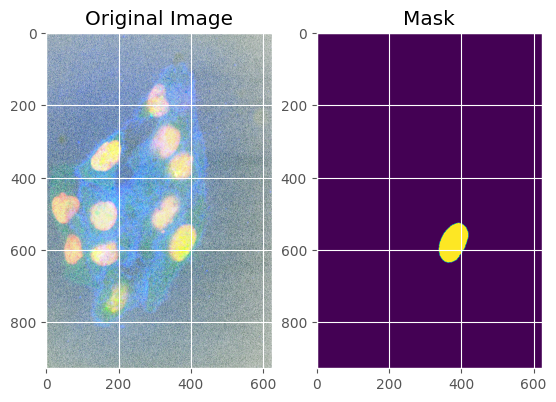

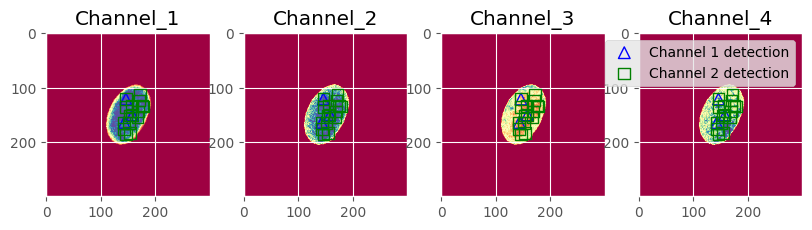

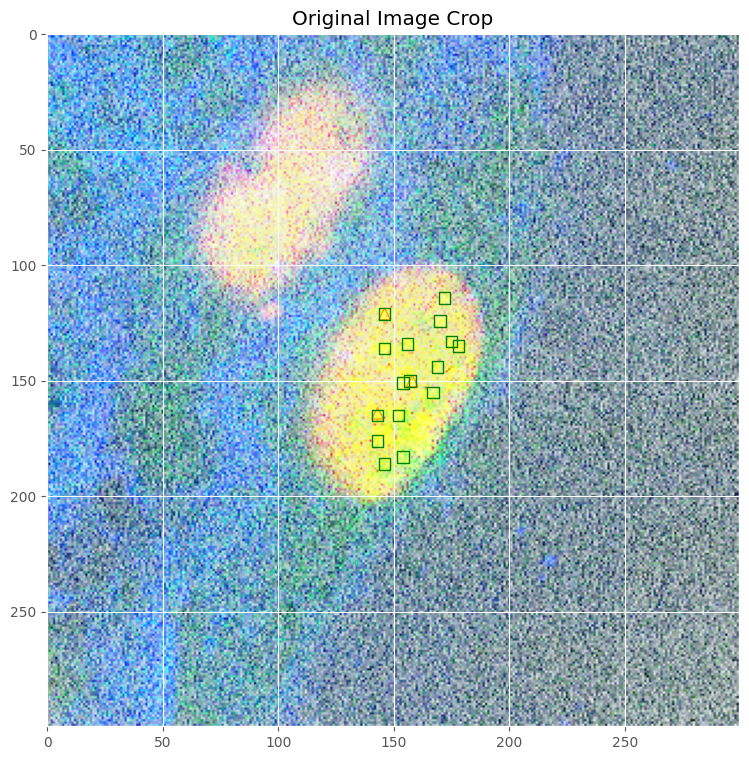

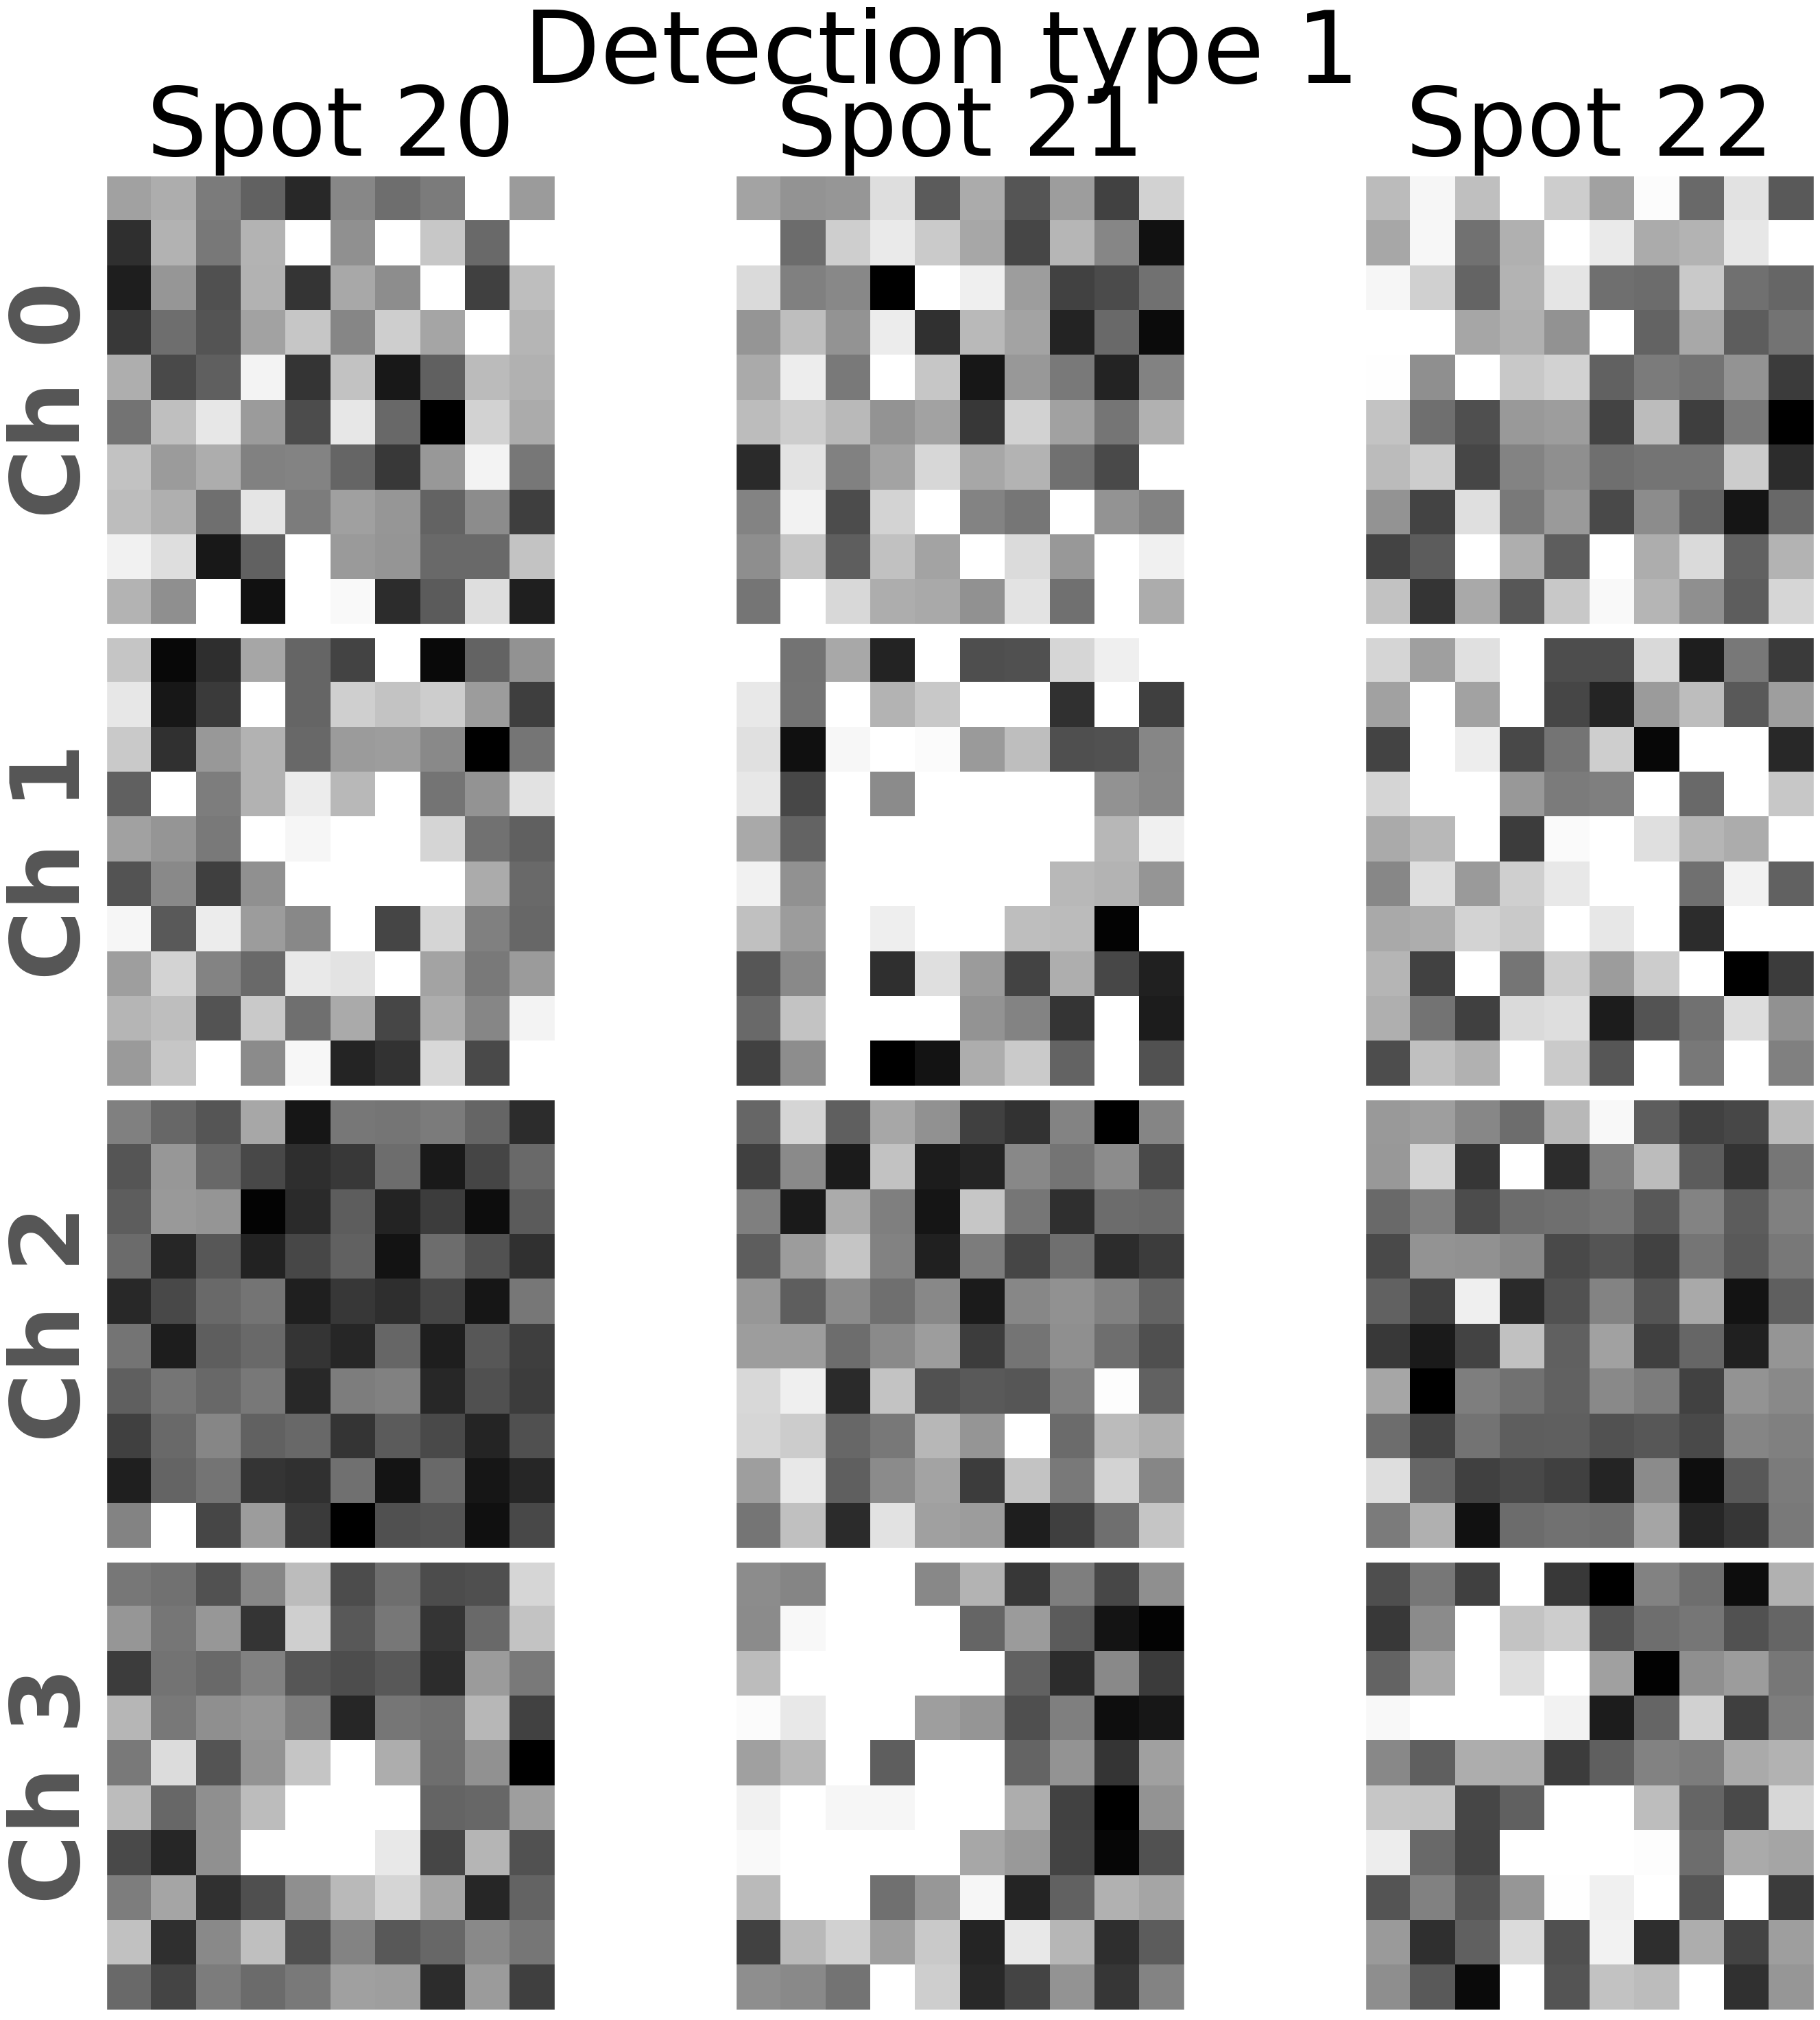

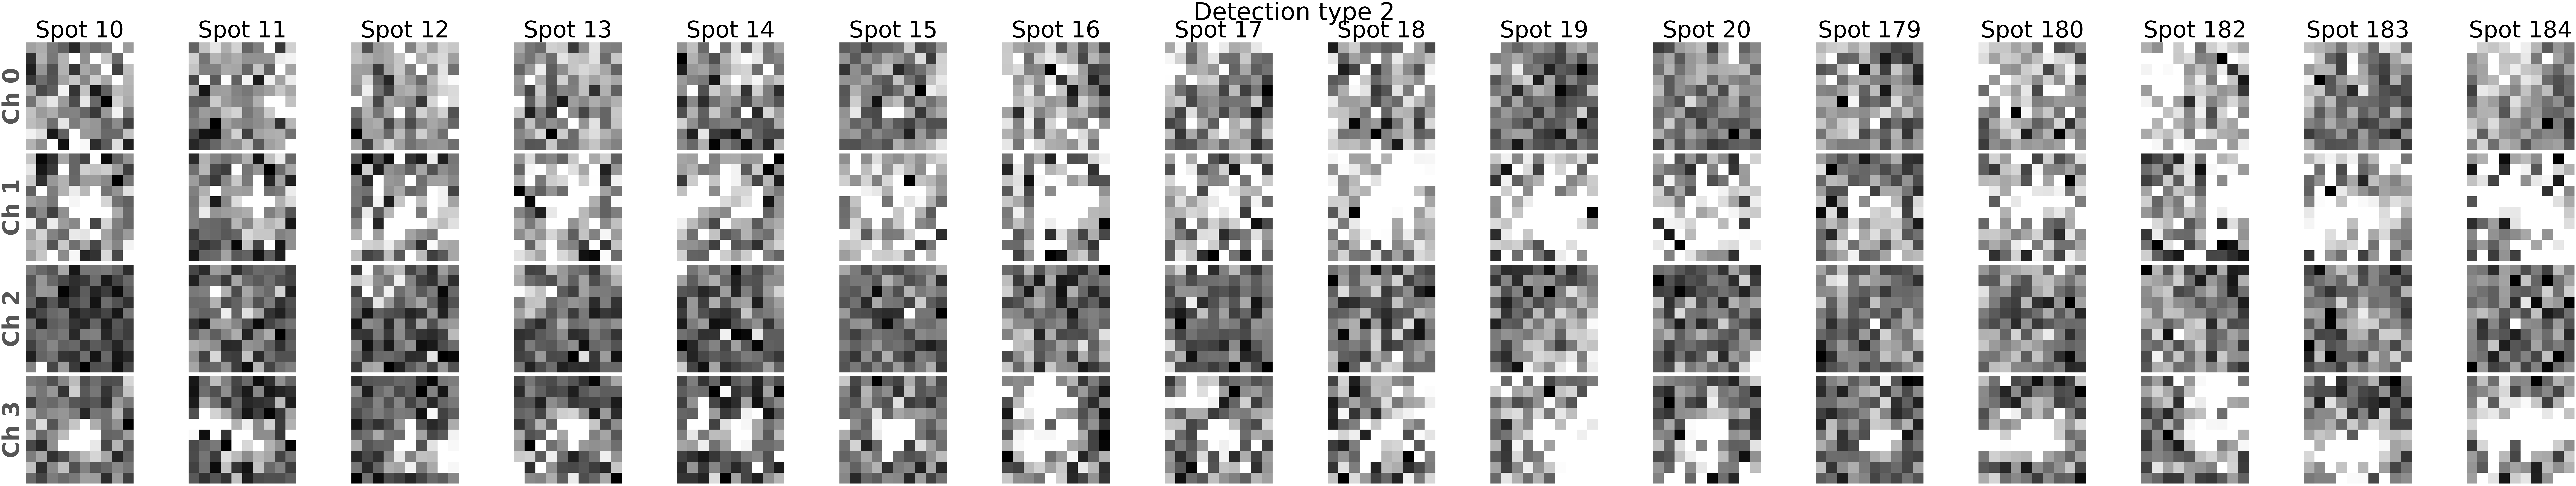

In [5]:
cell_ID=45
#string_name = 'A549_COX2_30ngmL_IL1B_2h_GoldMedia___nuc_90__cyto_200__psfz_350__psfyx_110__ts_600'
#string_name = 'MS2-CY5_Cyto543_560_woStim___nuc_60__cyto_180__psfz_350__psfyx_110__ts_300'
#string_name = 'MS2-Cy3___nuc_90__cyto_200__psfz_350__psfyx_110__ts_auto'
#string_name ='DUSP1_Dex_Sweep_0nM_0min_Control_092022___nuc_100__cyto_200__psfz_320__psfyx_120__ts_auto'
string_name = 'MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_400'

find_cell(cell_ID,string_name,x_width=150,y_height=150,z_slice=11,spots_show = [-1],delta_z=0)#,filter='saved filtered image',spot_filter='filtered spots')

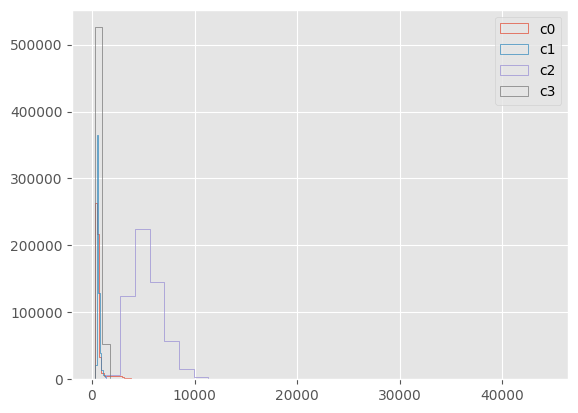

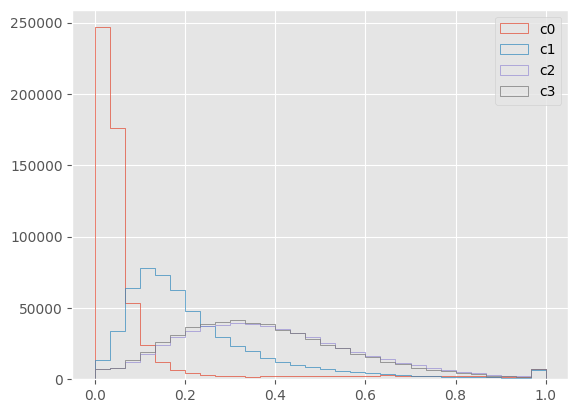

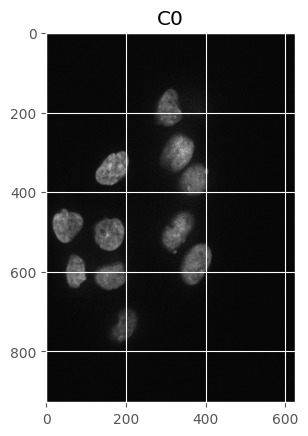

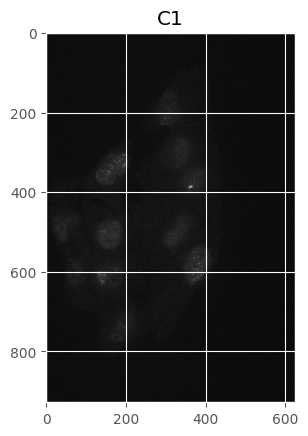

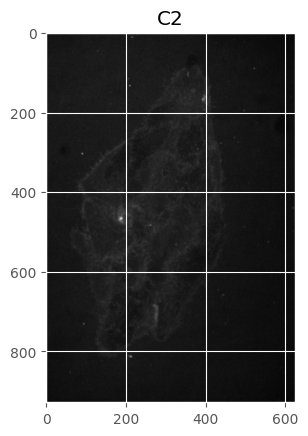

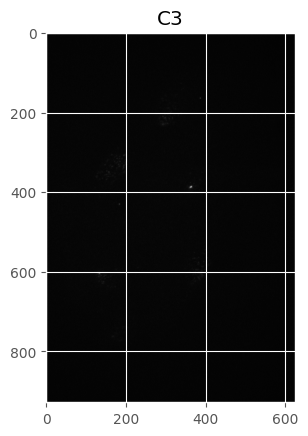

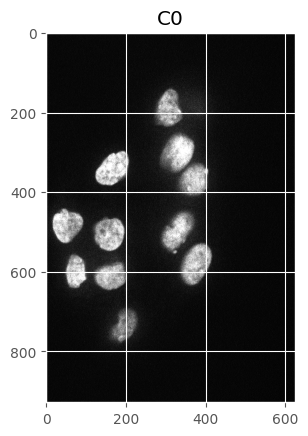

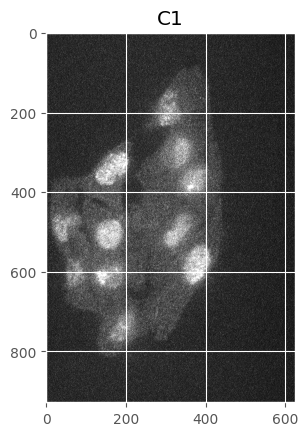

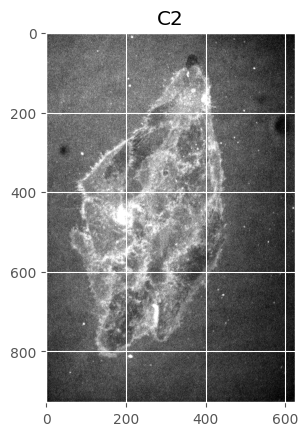

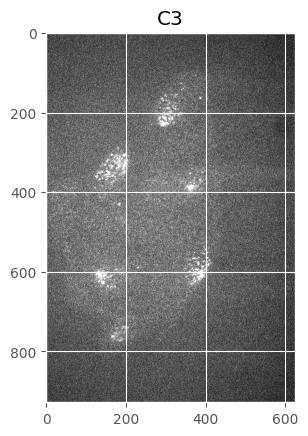

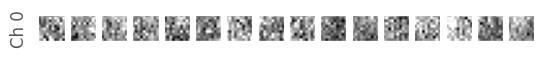

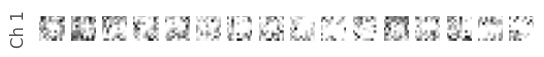

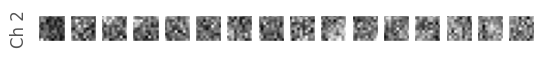

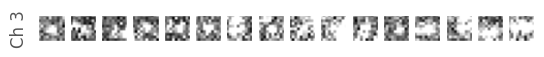

In [13]:
c0 = '/home/jcook10/Desktop/FISH_Processing/notebooks/temp_MS2-CY5_Cyto543_560_woStim/ROI004_XY1657814111_Z00_T0_C0.tif'
c1 = '/home/jcook10/Desktop/FISH_Processing/notebooks/temp_MS2-CY5_Cyto543_560_woStim/ROI004_XY1657814111_Z00_T0_C1.tif'
c2 = '/home/jcook10/Desktop/FISH_Processing/notebooks/temp_MS2-CY5_Cyto543_560_woStim/ROI004_XY1657814111_Z00_T0_C2.tif'
c3 = '/home/jcook10/Desktop/FISH_Processing/notebooks/temp_MS2-CY5_Cyto543_560_woStim/ROI004_XY1657814111_Z00_T0_C3.tif'
mid=11
c0_img = imread(c0)
c1_img = imread(c1)
c2_img = imread(c2)
c3_img = imread(c3)

#cm = [c0,c1,c2,c3]
#cwhole = np.zeros(np.shape(c0_img)[0],np.shape(c0_img)[1],np.shape(c0_img)[2],4)
#for c in len(range(cm)):
#   cwhole[mid,:,:,c] = imread(cm[c])



def quantile_norm(movie, q ):
   max_val = np.quantile(movie, q)
   min_val = np.quantile(movie, .005)
   norm_movie = (movie - min_val)/(max_val - min_val)
   norm_movie[norm_movie > 1] = 1
   norm_movie[norm_movie < 0] = 0
   return norm_movie

plt.figure()
plt.hist(c0_img[mid,:,:].flatten(),bins=30,  histtype='step')
plt.hist(c1_img[mid,:,:].flatten(),bins=30,  histtype='step')
plt.hist(c2_img[mid,:,:].flatten(),bins=30,  histtype='step')
plt.hist(c3_img[mid,:,:].flatten(),bins=30,  histtype='step')
plt.legend(['c0','c1','c2','c3'])

c0_img_norm = quantile_norm(c0_img[mid,:,:],.99)
c1_img_norm = quantile_norm(c1_img[mid,:,:],.99)
c2_img_norm = quantile_norm(c2_img[mid,:,:],.99)
c3_img_norm = quantile_norm(c3_img[mid,:,:],.99)

plt.figure()
plt.hist(c0_img_norm.flatten(),bins=30, histtype='step')
plt.hist(c1_img_norm.flatten(),bins=30, histtype='step')
plt.hist(c2_img_norm.flatten(),bins=30, histtype='step')
plt.hist(c3_img_norm.flatten(),bins=30, histtype='step')
plt.legend(['c0','c1','c2','c3'])

plt.figure()
plt.imshow(c0_img[mid,:,:],cmap='gray')
plt.title("C0")
plt.figure()
plt.imshow(c1_img[mid,:,:],cmap='gray')
plt.title("C1")
plt.figure()
plt.imshow(c2_img[mid,:,:],cmap='gray')
plt.title("C2")
plt.figure()
plt.imshow(c3_img[mid,:,:],cmap='gray')
plt.title("C3")

plt.figure()
plt.imshow(c0_img_norm,cmap='gray')
plt.title("C0")
plt.figure()
plt.imshow(c1_img_norm,cmap='gray')
plt.title("C1")
plt.figure()
plt.imshow(c2_img_norm,cmap='gray')
plt.title("C2")
plt.figure()
plt.imshow(c3_img_norm,cmap='gray')
plt.title("C3")

plt.show()

x= [372, 396, 401, 382, 404, 395, 383, 369, 369, 380, 372, 398, 372, 380, 393, 378]
y= [552, 555, 564, 565, 566, 575, 581, 596, 607, 614, 617, 545, 567, 582, 586, 596]
num=5

fig = plt.figure(1)
plt.figure(1)
for i in range(len(x)):
   axes = fig.add_subplot(1,len(x) , i+1)
   plt.imshow(c0_img_norm[y[i]-num:y[i]+num,x[i]-num:x[i]+num],cmap='gray')
   if i == 0:
      axes.set_ylabel('Ch 0')
   axes.set_xticks([])
   axes.set_yticks([])

fig2 = plt.figure(2)
plt.figure(2)
for i in range(len(x)):
   axes2 = fig2.add_subplot(1,len(x) , i+1)
   plt.imshow(c1_img_norm[y[i]-num:y[i]+num,x[i]-num:x[i]+num],cmap='gray')
   if i == 0:
      axes2.set_ylabel('Ch 1')
   axes2.set_xticks([])
   axes2.set_yticks([])

fig3 = plt.figure(3)
plt.figure(3)
for i in range(len(x)):
   axes3 = fig3.add_subplot(1,len(x) , i+1)
   plt.imshow(c2_img_norm[y[i]-num:y[i]+num,x[i]-num:x[i]+num],cmap='gray')
   if i == 0:
      axes3.set_ylabel('Ch 2')
   axes3.set_xticks([])
   axes3.set_yticks([])

fig4 = plt.figure(4)
plt.figure(4)
for i in range(len(x)):
   axes4 = fig4.add_subplot(1,len(x) , i+1)
   plt.imshow(c3_img_norm[y[i]-num:y[i]+num,x[i]-num:x[i]+num],cmap='gray')
   if i == 0:
      axes4.set_ylabel('Ch 3')
   axes4.set_xticks([])
   axes4.set_yticks([])



plt.show()

